# Cardiovascular Predictive Model

This project aims to analyze the [Cardiovascular Study Dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea/data) Dataset and develop a predictive model to assess the 10-year risk of coronary heart disease (CHD). The analysis will involve data loading and cleaning, exploratory data analysis (EDA), and building a logistic regression model to evaluate CHD risk.

The structure is roughly as follows:

- Data loading and cleaning
- EDA
- Modelling


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [84]:
df = pd.read_csv("train.csv")
df.shape

(3390, 17)

In [85]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


- Check for missing values

In [86]:
df.isnull().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

### Handling Missing Values


- Education: Since this is likely a categorical variable, we could:

  - Fill with the most frequent value (mode).
  - Treat it as a separate category ("Unknown") if it fits the context.
- cigsPerDay: Since this is probably a numerical variable, we could:

  - Fill with the median (less sensitive to outliers than the mean).
  - Or use 0 if it makes sense to assume no cigarettes if information is missing.
- BPMeds: If this is a binary variable (indicating whether or not someone is on blood pressure medication), we could:

 - Fill with the mode or assume "not on medication" if the context allows.

In [87]:
# Fill missing values for 'education' with mode
df['education'].fillna(df['education'].mode()[0], inplace=True)

# Fill missing values for 'cigsPerDay' with median
df['cigsPerDay'].fillna(df['cigsPerDay'].median(), inplace=True)

# Fill missing values for 'BPMeds' with mode (assuming binary indicator for medication)
df['BPMeds'].fillna(df['BPMeds'].mode()[0], inplace=True)

# Confirm that there are no more missing values
df.isnull().sum()


id                   0
age                  0
education            0
sex                  0
is_smoking           0
cigsPerDay           0
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [88]:
# Overview of data types and basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3390 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3390 non-null   float64
 6   BPMeds           3390 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

- We still have missing values. let us handle them

In [89]:
# Fill missing values for 'totChol', 'BMI', and 'heartRate' with their respective medians
df['totChol'].fillna(df['totChol'].median(), inplace=True)
df['BMI'].fillna(df['BMI'].median(), inplace=True)
df['heartRate'].fillna(df['heartRate'].median(), inplace=True)

# For 'glucose', fill with median as a tentative step, but review if it impacts results
df['glucose'].fillna(df['glucose'].median(), inplace=True)

# Verify there are no more missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3390 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3390 non-null   float64
 6   BPMeds           3390 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3390 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3390 non-null   float64
 14  heartRate        3390 non-null   float64
 15  glucose          3390 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

- Check for duplicates

In [90]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


- Drop irrelevant columns

In [91]:
df = df.drop(columns=['id'])
print("Irrelevant columns dropped.")


Irrelevant columns dropped.


In [92]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,3390.0,49.542183,8.592878,32.00,42.00,49.00,56.0000,70.0
education,3390.0,1.946018,1.017568,1.00,1.00,2.00,3.0000,4.0
cigsPerDay,3390.0,9.010619,11.862839,0.00,0.00,0.00,20.0000,70.0
BPMeds,3390.0,0.029499,0.169224,0.00,0.00,0.00,0.0000,1.0
prevalentStroke,3390.0,0.006490,0.080309,0.00,0.00,0.00,0.0000,1.0
prevalentHyp,3390.0,0.315339,0.464719,0.00,0.00,0.00,1.0000,1.0
diabetes,3390.0,0.025664,0.158153,0.00,0.00,0.00,0.0000,1.0
totChol,3390.0,237.039823,44.994205,107.00,206.00,234.00,264.0000,696.0
sysBP,3390.0,132.601180,22.292030,83.50,117.00,128.50,144.0000,295.0
diaBP,3390.0,82.883038,12.023581,48.00,74.50,82.00,90.0000,142.5


# Exploratory Data Analysis (EDA)

**1. Univariate Analysis**

Plot the distribution of each numerical feature to get a sense of its range, mean, and skewness.
For categorical variables like sex and is_smoking, check the count distribution.

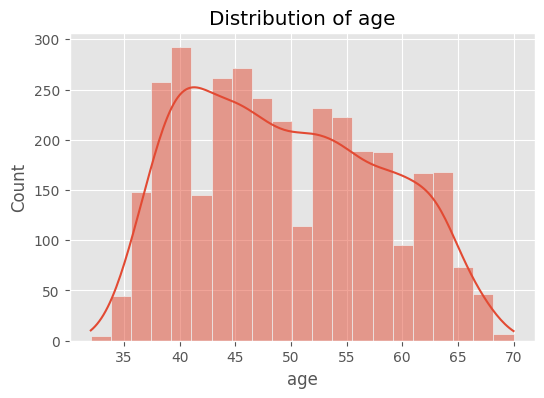

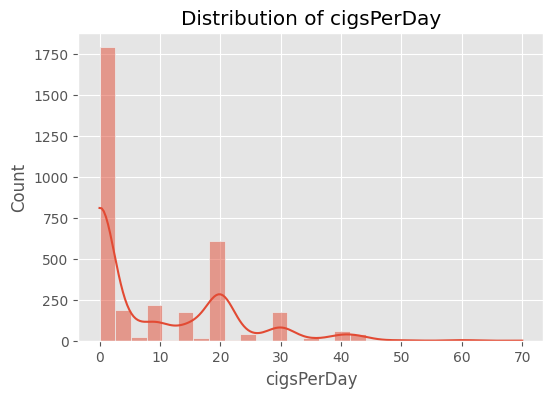

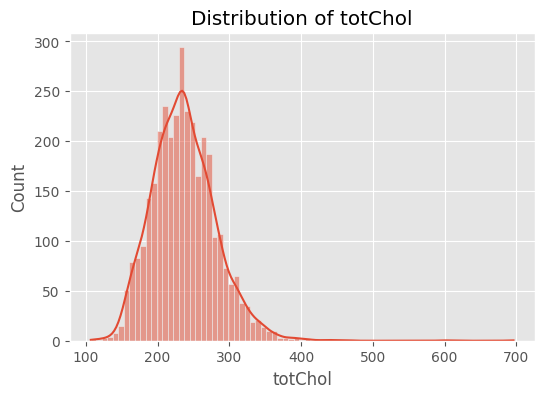

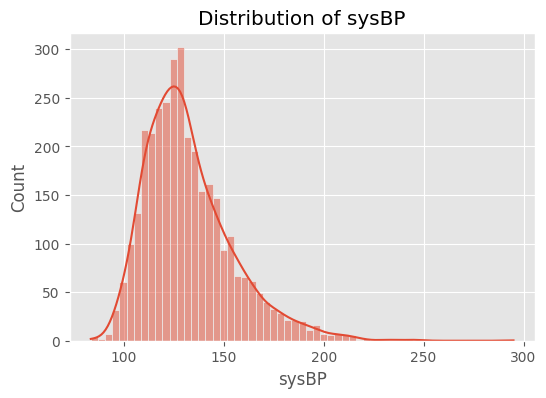

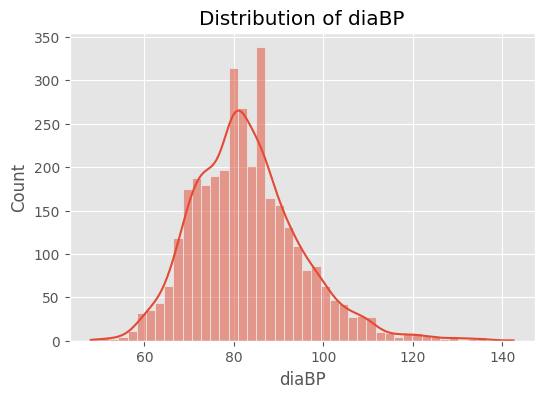

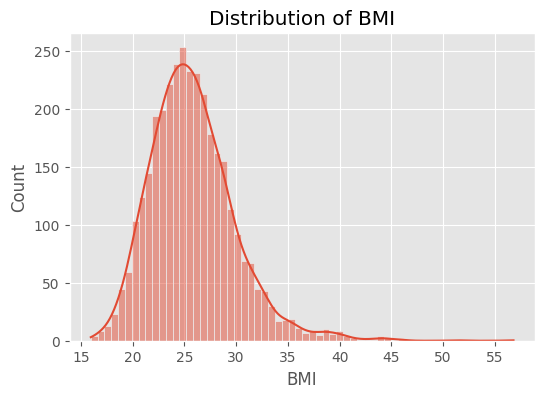

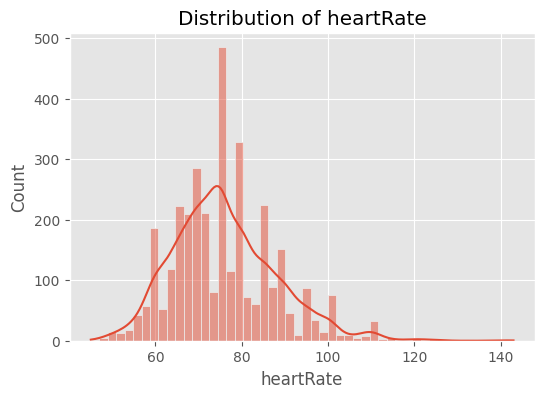

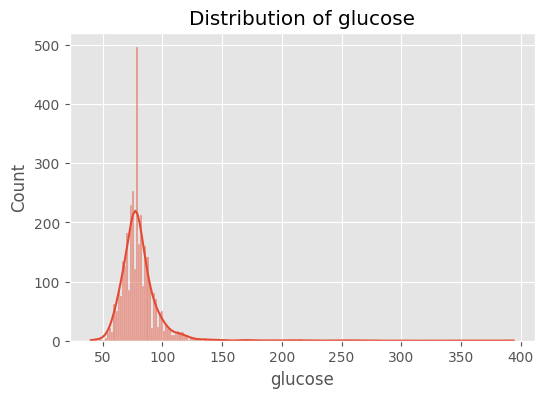

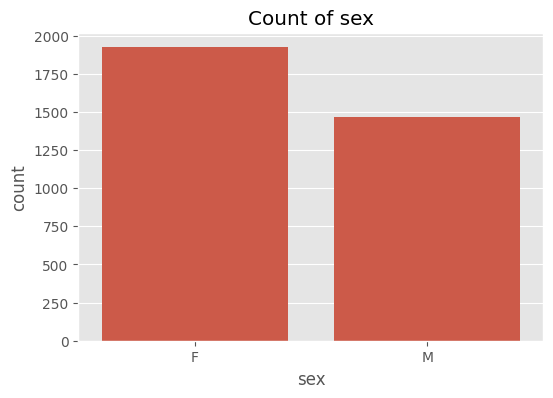

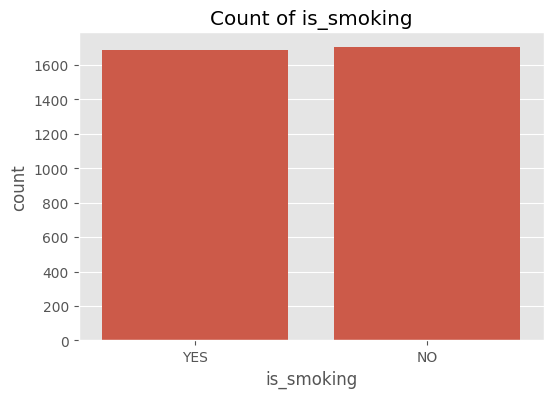

In [93]:
# Plot distribution of continuous variables
continuous_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.show()

# Plot distribution of categorical variables
categorical_vars = ['sex', 'is_smoking']
for var in categorical_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=var, data=df)
    plt.title(f'Count of {var}')
    plt.show()


## 2. Bivariate Analysis

- we use boxplot to check outliers

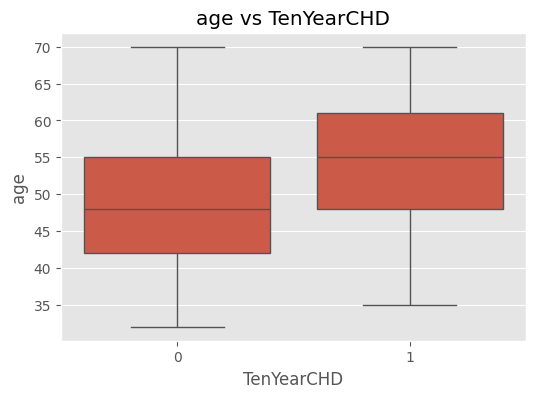

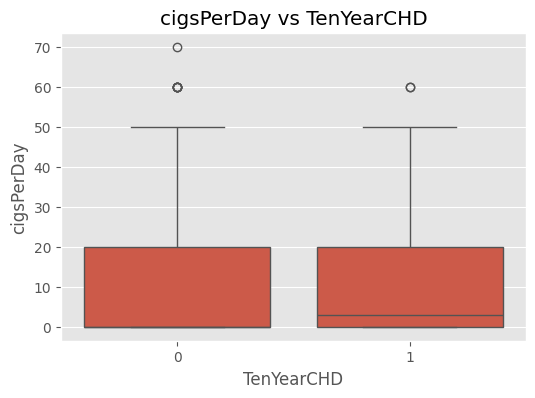

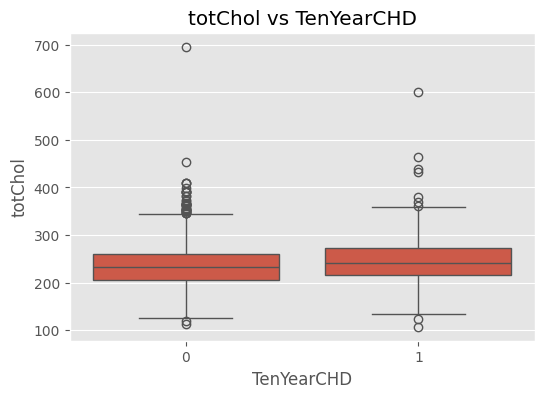

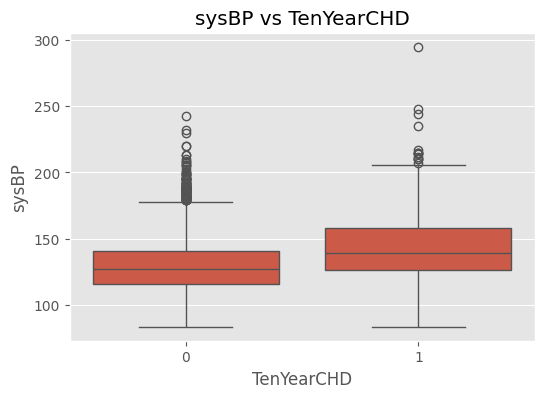

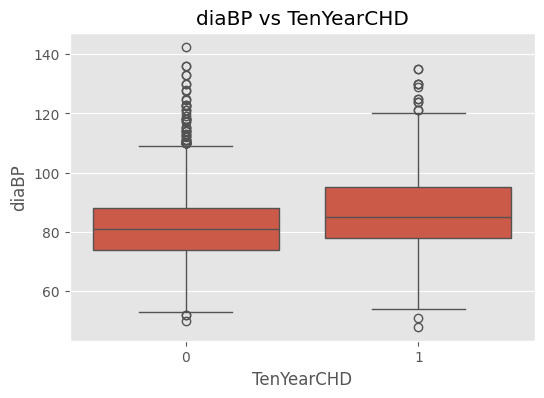

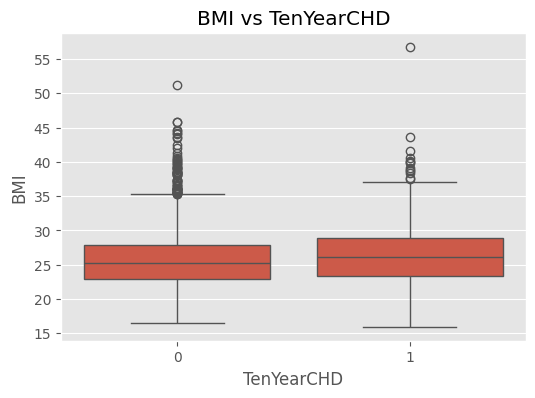

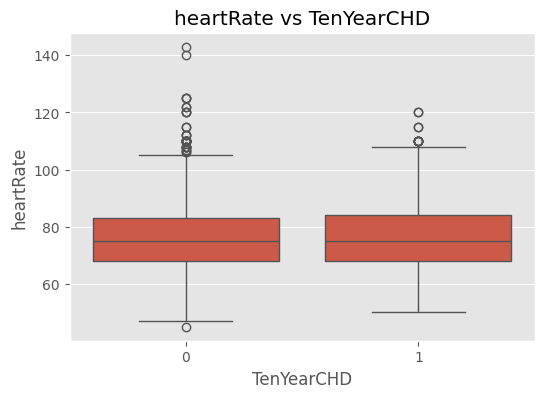

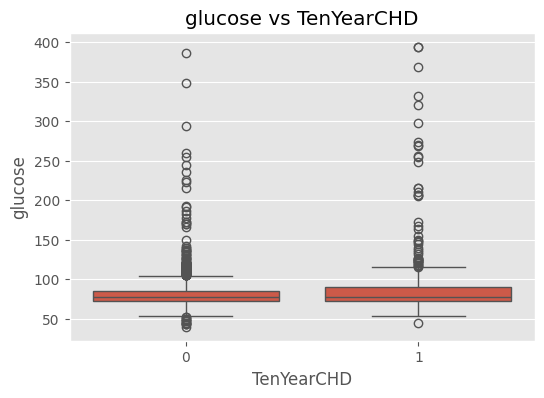

In [94]:
# Plot target variable against continuous variables
for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='TenYearCHD', y=var, data=df)
    plt.title(f'{var} vs TenYearCHD')
    plt.show()


- **Since this is medical data, and outliers could indicate high-risk individuals for coronary heart disease:**

We decided to preserve outliers but use transformations to reduce their impact.
Experiment with the model’s performance with and without outliers. This way, we can verify if outlier handling meaningfully impacts our results.

- Winsorization
  - This approach caps extreme values at a certain percentile, making the extreme values less influential.

In [95]:
# Apply Winsorization to cap outliers
for col in continuous_vars:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])  # Capping at the 1st and 99th percentiles

- Standardize the Data
  - Standardizing (z-score normalization) can help make the outliers less impactful by scaling features. This doesn’t remove outliers but can make them less influential in models like logistic regression.

In [96]:
# Standardize continuous variables
scaler = StandardScaler()
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

Correlation Analysis (Heatmap):

A correlation heatmap will help us understand the linear relationships between the continuous variables and check for multicollinearity, which can affect model performance.

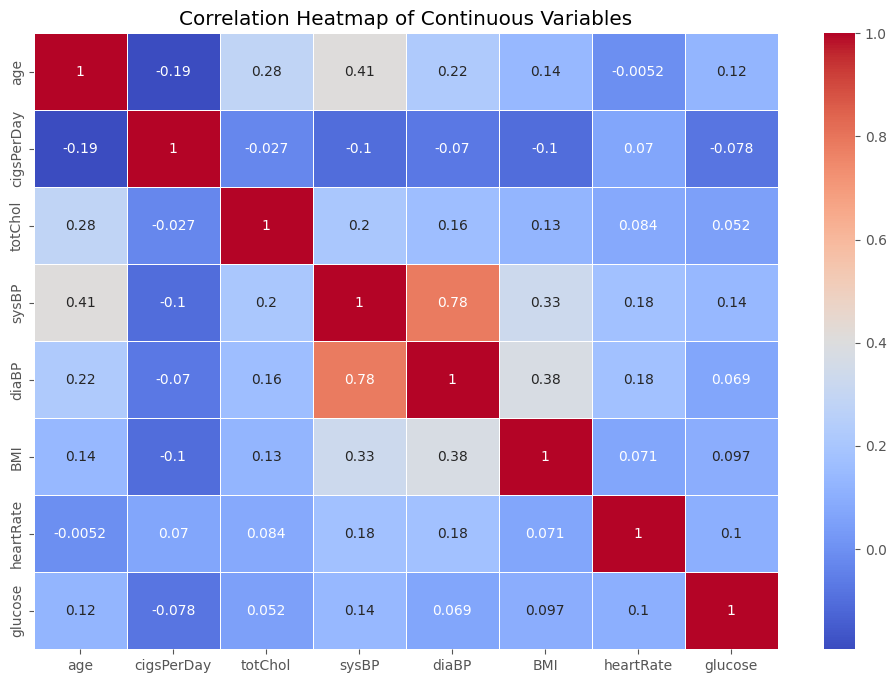

In [97]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[continuous_vars].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Continuous Variables")
plt.show()


- **Encoding Categorical Variables:**

Since sex and is_smoking are categorical, let’s convert them to numeric values (0 and 1) using label encoding to prepare them for the model.

In [98]:
# Encode 'sex' and 'is_smoking' columns
df['sex'] = df['sex'].map({'M': 1, 'F': 0})  # Assuming 'M' for Male and 'F' for Female
df['is_smoking'] = df['is_smoking'].map({'YES': 1, 'NO': 0})  # Assuming 'YES' and 'NO' as the categories


# Building and Training the Logistic Regression Model

In [99]:
# Define target and features
X = df.drop(['TenYearCHD'], axis=1)  # Target column already clean
y = df['TenYearCHD']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.689399,2.0,0,1,-0.511052,0.0,0,0,0,-0.367348,0.717587,0.183711,-0.098365,1.201297,-0.056758,1
1,-1.582207,4.0,1,0,-0.768769,0.0,0,1,0,-0.577913,1.642256,1.294373,1.010714,-0.335875,-0.361591,0
2,-0.413776,1.0,0,1,0.090290,0.0,0,0,0,0.311142,-0.761884,-1.012385,-1.369132,1.030500,0.796774,0
3,0.053596,1.0,1,1,0.949349,0.0,0,1,0,-0.086593,1.179921,0.440018,0.629231,-0.677469,0.796774,1
4,1.689399,1.0,0,1,1.808409,0.0,0,0,0,0.100576,0.185902,0.183711,0.164378,-0.506672,-0.239658,0


## Model Training
**We will:**

1. Create and fit a logistic regression model using the training data (`X_train`,` y_train`).
1. Evaluate the model on the test data (`X_test`, `y_test`) using appropriate metrics.


Accuracy: 0.87
Confusion Matrix:
[[580   1]
 [ 88   9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       581
           1       0.90      0.09      0.17        97

    accuracy                           0.87       678
   macro avg       0.88      0.55      0.55       678
weighted avg       0.87      0.87      0.82       678

AUC-ROC: 0.73


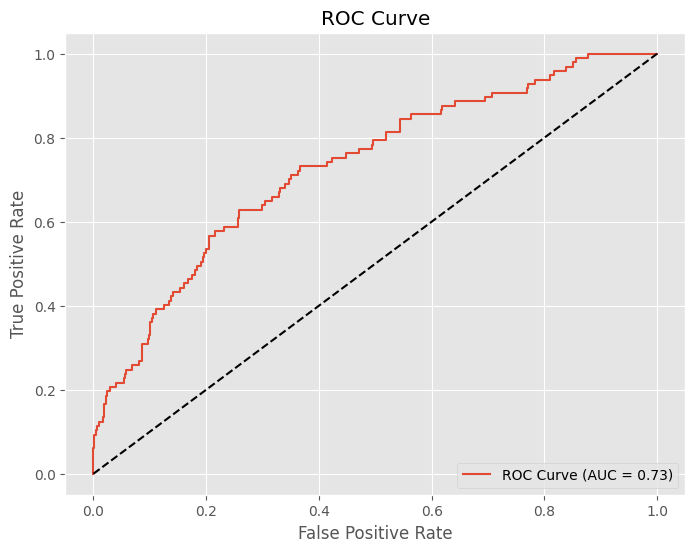

In [101]:
# Step 1: Initialize and train the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Step 2: Predict on the test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Step 3: Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.2f}")

# Step 4: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


### Issues Identified
1. **Imbalanced Dataset**: The low recall for CHD cases (1) suggests the model struggles with the minority class.
2. **Threshold Optimization:** The default threshold of 0.5 may not be optimal for this problem, where false negatives (missed CHD cases) are more critical than false positives.

- Optimize the Classification Threshold:

  - Adjust the threshold to improve recall for CHD cases. Use the ROC curve and metrics like precision-recall trade-off to select a better threshold.

In [102]:
# Find the optimal threshold
thresholds = np.arange(0.1, 1.0, 0.1)  # Range of thresholds
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f} | Recall: {recall:.2f} | Precision: {precision:.2f}")


Threshold: 0.10 | Recall: 0.78 | Precision: 0.21
Threshold: 0.20 | Recall: 0.52 | Precision: 0.30
Threshold: 0.30 | Recall: 0.26 | Precision: 0.36
Threshold: 0.40 | Recall: 0.16 | Precision: 0.57
Threshold: 0.50 | Recall: 0.09 | Precision: 0.90
Threshold: 0.60 | Recall: 0.05 | Precision: 1.00
Threshold: 0.70 | Recall: 0.01 | Precision: 1.00
Threshold: 0.80 | Recall: 0.00 | Precision: 0.00
Threshold: 0.90 | Recall: 0.00 | Precision: 0.00


## Analysis of Threshold Results
**1. Threshold 0.10:**

- Recall (0.78): The model correctly identifies 78% of CHD cases.
- Precision (0.21): Only 21% of the predicted CHD cases are correct.
- This threshold favors high recall but sacrifices precision.
 
**2. Threshold 0.50 (Default):**

- Recall (0.09): The model only identifies 9% of CHD cases.
- Precision (0.90): 90% of predicted CHD cases are correct.
- This threshold favors precision but is too low on recall, making it unsuitable for a medical application.

**3. Trade-off:**

- A lower threshold (e.g., 0.10 or 0.20) achieves higher recall, which is essential for reducing missed CHD cases.
- The goal is to strike a balance where recall is sufficient while maintaining reasonable precision.


- Use Threshold = 0.20:

In [103]:
# Apply the chosen threshold
chosen_threshold = 0.20
y_pred_thresh = (y_pred_proba >= chosen_threshold).astype(int)

# Reevaluate the model with the new threshold
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix at Threshold 0.20:")
print(confusion_matrix(y_test, y_pred_thresh))

print("\nClassification Report at Threshold 0.20:")
print(classification_report(y_test, y_pred_thresh))


Confusion Matrix at Threshold 0.20:
[[467 114]
 [ 47  50]]

Classification Report at Threshold 0.20:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       581
           1       0.30      0.52      0.38        97

    accuracy                           0.76       678
   macro avg       0.61      0.66      0.62       678
weighted avg       0.82      0.76      0.79       678



### Strengths:

- Recall for CHD cases has improved significantly, making the model more suitable for identifying at-risk individuals.
The trade-off between recall and precision is acceptable given the context (medical predictions prioritize recall to minimize false negatives).
### Weaknesses:

- Precision for CHD cases is low (0.30), meaning many false positives.
This might result in unnecessary follow-ups for some patients but is less critical than missing CHD cases.

## Using Class Weight Adjustment
Update the logistic regression model with balanced class weights.

In [104]:
# Logistic Regression with class weight balanced
logreg_balanced = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg_balanced.fit(X_train, y_train)

# Predict and evaluate
y_pred_balanced = logreg_balanced.predict(X_test)
y_pred_proba_balanced = logreg_balanced.predict_proba(X_test)[:, 1]

print("Confusion Matrix (Class-Weighted):")
print(confusion_matrix(y_test, y_pred_balanced))

print("\nClassification Report (Class-Weighted):")
print(classification_report(y_test, y_pred_balanced))

Confusion Matrix (Class-Weighted):
[[411 170]
 [ 36  61]]

Classification Report (Class-Weighted):
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       581
           1       0.26      0.63      0.37        97

    accuracy                           0.70       678
   macro avg       0.59      0.67      0.59       678
weighted avg       0.83      0.70      0.74       678



### Insights
### Strengths:

- Improved Recall for CHD Cases (Class 1): The model identifies 63% of CHD cases, a significant improvement for a medical prediction task.
The trade-off is acceptable, given that identifying at-risk patients is the priority.
### Weaknesses:

- High False Positive Rate: 170 non-CHD cases are classified as CHD, which could lead to unnecessary follow-ups or interventions.

In [105]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit logistic regression on the resampled data
logreg_smote = LogisticRegression(random_state=42, max_iter=1000)
logreg_smote.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_smote = logreg_smote.predict(X_test)
y_pred_proba_smote = logreg_smote.predict_proba(X_test)[:, 1]

print("Confusion Matrix (SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))

print("\nClassification Report (SMOTE):")
print(classification_report(y_test, y_pred_smote))


Confusion Matrix (SMOTE):
[[402 179]
 [ 36  61]]

Classification Report (SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       581
           1       0.25      0.63      0.36        97

    accuracy                           0.68       678
   macro avg       0.59      0.66      0.58       678
weighted avg       0.82      0.68      0.73       678



# Interpret the Model

In [106]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg_balanced.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(feature_importance)


            Feature  Coefficient
6   prevalentStroke     1.017077
0               age     0.560719
2               sex     0.461103
5            BPMeds     0.336616
10            sysBP     0.318801
4        cigsPerDay     0.241065
8          diabetes     0.173465
3        is_smoking     0.143430
14          glucose     0.139845
7      prevalentHyp     0.085446
9           totChol     0.076779
11            diaBP    -0.002706
12              BMI    -0.005250
1         education    -0.035156
13        heartRate    -0.085762


- Visualized coefficients

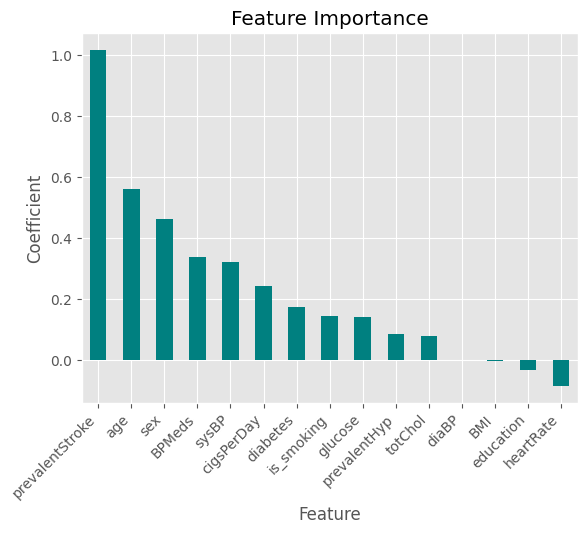

In [107]:
feature_importance.plot(kind='bar', x='Feature', y='Coefficient', color='teal', legend=False)
plt.title('Feature Importance')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()


## Feature Importance Interpretation
> The coefficients indicate how each feature influences the likelihood of CHD risk:

- Positive Coefficients:

  - Features with positive coefficients increase the risk of CHD.
   - Top 3 positive contributors:
     - prevalentStroke (1.017): A history of stroke significantly increases CHD risk.
     - age (0.561): Older age contributes strongly to higher CHD risk.
     - sex (0.461): Suggests that one gender (likely males if encoded as 1) has a higher CHD risk.
- Negative Coefficients:

  - Features with negative coefficients decrease the likelihood of CHD.
  - Key contributors:
     - heartRate (-0.086): A lower heart rate may be associated with reduced CHD risk.
     - education (-0.035): Higher education may correlate with lower CHD risk.
- Other Observations:

  - Blood pressure measures (sysBP: 0.319 and diaBP: -0.003) show moderate influence, with systolic pressure being more important.
  - cigsPerDay (0.241) and is_smoking (0.143) confirm the role of smoking in increasing CHD risk.


# Actionable Insights
1. **High-Risk Groups:** Focus on individuals with a history of stroke, older age, and high systolic blood pressure.
2. **Prevention Strategies:** Target smoking cessation programs and diabetes management to reduce CHD risks.
3. **Further Research:** Investigate why features like heart rate and education are protective and how these can guide public health strategies.

# Final Recommendations

### 1. Public Health Recommendations
- **Targeted Screening**:  
  - Regular cardiovascular checkups for individuals with high-risk factors like stroke history, older age, and hypertension.
  
- **Lifestyle Interventions**:  
  - Prioritize smoking cessation programs.  
  - Encourage physical activity and dietary changes to manage blood pressure, glucose, and cholesterol levels.

- **Educational Campaigns**:  
  - Raise awareness about CHD risk factors, especially in underserved populations.

- **Policy Recommendations**:  
  - Advocate for subsidized medications and routine screenings to manage blood pressure and glucose levels.

### 2. Model Deployment & Future Research
- **Model Deployment**:  
  - The trained logistic regression model could be integrated into a clinical decision-support system for early risk prediction of CHD.

- **Future Improvements**:  
  - Explore more complex models like Random Forest or Gradient Boosting to improve precision without sacrificing recall.  
  - Collect additional data to enhance model generalizability, particularly for minority CHD cases.

### 3. Limitations
- **Imbalanced Dataset**:  
  - Despite efforts to handle class imbalance, the precision for CHD cases remains low.

- **Model Simplicity**:  
  - Logistic regression is interpretable but may not capture complex nonlinear relationships.
